In [1]:
import pandas as pd
import scipy.io
import scanpy as sc
import gzip

# Paths to files
mtx_file = "/mnt/data/melhajjar/tabula_muris/lung_raw_data/matrix/matrix.mtx.gz"
features_file = "/mnt/data/melhajjar/tabula_muris/lung_raw_data/matrix/features.tsv.gz"
barcodes_file = "/mnt/data/melhajjar/tabula_muris/lung_raw_data/matrix/barcodes.tsv.gz"

# Read barcodes and features
barcodes_df = pd.read_csv(barcodes_file, sep='\t', header=None)
features_df = pd.read_csv(features_file, sep='\t', header=None)

# Read and transpose matrix
with gzip.open(mtx_file, 'rb') as f:
    matrix = scipy.io.mmread(f).T  # Transpose to shape (cells, genes)

# Convert to CSR format immediately
matrix = matrix.tocsr()

# Create AnnData object
adata = sc.AnnData(X=matrix)
adata.obs_names = barcodes_df[0].values
adata.var_names = features_df[1].values  # Gene symbols
adata.var['gene_ids'] = features_df[0].values
if features_df.shape[1] > 2:
    adata.var['feature_types'] = features_df[2].values

# Ensure adata is not a view
adata = adata.copy()

# Confirm all sparse matrices are in CSR format
adata.X = adata.X.tocsr()  # Main matrix
if hasattr(adata, "raw") and adata.raw is not None:
    adata.raw.X = adata.raw.X.tocsr()

# Now filter cells and genes
sc.pp.filter_cells(adata, min_genes=100)  # Filter cells with at least 100 genes
sc.pp.filter_genes(adata, min_cells=3)   # Filter genes expressed in at least 3 cells

# Check results
print(adata)


AnnData object with n_obs × n_vars = 24540 × 16938
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'


In [2]:
# Path to metadata file
metadata_file = "/mnt/data/melhajjar/tabula_muris/GSM4505404_tabula-muris-senis-droplet-official-raw-obj-metadata.csv"

# Load metadata
metadata = pd.read_csv(metadata_file, index_col=0)  # Use the barcode column as the index

metadata = metadata.loc[metadata.index.isin(adata.obs_names)]

metadata

/tmp/ipykernel_14186/4278562362.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadata_file, index_col=0)  # Use the barcode column as the index


,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_genes,sex,subtissue,tissue,tissue_free_annotation
index,,,,,,,,,,,,
AAACGGGTCGCCCTTA-1-11-0-0,18m,MACA_18m_F_LUNG_50_AAACGGGTCGCCCTTA,B cell,NaN,B,droplet,18-F-50,1821.0,female,NaN,Lung,Lung
AAAGATGAGCAGACTG-1-11-0-0,18m,MACA_18m_F_LUNG_50_AAAGATGAGCAGACTG,non-classical monocyte,NaN,Nonclassical Monocyte,droplet,18-F-50,1333.0,female,NaN,Lung,Lung
AAAGATGAGCCGTCGT-1-11-0-0,18m,MACA_18m_F_LUNG_50_AAAGATGAGCCGTCGT,NK cell,NaN,Natural Killer,droplet,18-F-50,1455.0,female,NaN,Lung,Lung
AAAGCAACATGGTAGG-1-11-0-0,18m,MACA_18m_F_LUNG_50_AAAGCAACATGGTAGG,alveolar macrophage,NaN,Alveolar Macrophage,droplet,18-F-50,3322.0,female,NaN,Lung,Lung
AAAGCAAGTCTAGTGT-1-11-0-0,18m,MACA_18m_F_LUNG_50_AAAGCAAGTCTAGTGT,B cell,NaN,B,droplet,18-F-50,1120.0,female,NaN,Lung,Lung
...,...,...,...,...,...,...,...,...,...,...,...,...
10X_P8_13_TTTGGTTAGGGATACC-1,3m,10X_P8_13_TTTGGTTAGGGATACC,fibroblast of lung,CL:0000499,Alveolar Fibroblast,droplet,3-M-7/8,NaN,male,immune-endo-depleted,Lung,Lung
10X_P8_13_TTTGGTTTCCTGTACC-1,3m,10X_P8_13_TTTGGTTTCCTGTACC,NK cell,CL:0000623,Natural Killer,droplet,3-M-7/8,NaN,male,immune-endo-depleted,Lung,Lung
10X_P8_13_TTTGTCAAGAGTCGGT-1,3m,10X_P8_13_TTTGTCAAGAGTCGGT,pulmonary interstitial fibroblast,CL:0000499,Myofibroblast,droplet,3-M-7/8,NaN,male,immune-endo-depleted,Lung,Lung


In [3]:
# Reindex metadata to match adata.obs_names
metadata = metadata.reindex(adata.obs_names, fill_value=None)  # Fill missing with NaN (optional)

# Drop any rows with NaN to remove unmatched barcodes (optional)
metadata = metadata.dropna(how="all")

In [4]:
adata.obs = adata.obs.join(metadata, rsuffix="_meta")

# Check the result
print(adata.obs.head())

                           n_genes  age                                 cell  \
AAACGGGTCGCCCTTA-1-11-0-0     1821  18m  MACA_18m_F_LUNG_50_AAACGGGTCGCCCTTA   
AAAGATGAGCAGACTG-1-11-0-0     1333  18m  MACA_18m_F_LUNG_50_AAAGATGAGCAGACTG   
AAAGATGAGCCGTCGT-1-11-0-0     1455  18m  MACA_18m_F_LUNG_50_AAAGATGAGCCGTCGT   
AAAGCAACATGGTAGG-1-11-0-0     3322  18m  MACA_18m_F_LUNG_50_AAAGCAACATGGTAGG   
AAAGCAAGTCTAGTGT-1-11-0-0     1120  18m  MACA_18m_F_LUNG_50_AAAGCAAGTCTAGTGT   

                              cell_ontology_class cell_ontology_id  \
AAACGGGTCGCCCTTA-1-11-0-0                  B cell              NaN   
AAAGATGAGCAGACTG-1-11-0-0  non-classical monocyte              NaN   
AAAGATGAGCCGTCGT-1-11-0-0                 NK cell              NaN   
AAAGCAACATGGTAGG-1-11-0-0     alveolar macrophage              NaN   
AAAGCAAGTCTAGTGT-1-11-0-0                  B cell              NaN   

                                 free_annotation   method mouse.id  \
AAACGGGTCGCCCTTA-1-11-0-0   

In [5]:
# Filter out samples where adata.obs['sex'] is "female"
adata = adata[adata.obs['sex'] != "female"]

In [6]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

/tmp/ipykernel_14186/2262359327.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [7]:
# Define the specific cell types of interest
selected_cell_types = [
    "classical monocyte",
    "non-classical monocyte",
    "alveolar macrophage",
    "lung macrophage",
    "intermediate monocyte"
]

# Create a dictionary of AnnData objects for each selected cell type
selected_adata_dfs = {cell_type: adata[adata.obs['cell_ontology_class'] == cell_type].copy()
                      for cell_type in selected_cell_types}

# Print number of cells per selected type
for cell_type, adata_subset in selected_adata_dfs.items():
    print(f"{cell_type}: {adata_subset.shape[0]} cells")

classical monocyte: 7407 cells
non-classical monocyte: 553 cells
alveolar macrophage: 1044 cells
lung macrophage: 1123 cells
intermediate monocyte: 1659 cells


Processing all selected cell types together...
Processing age group 1m...
Processing age group 3m...
Processing age group 18m...
Processing age group 30m...


/tmp/ipykernel_6321/4147373273.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata_selected.obs.groupby(['age', 'cell_ontology_class']).size().unstack(fill_value=0)


All figures have been saved in: /home/melhajjar/ipython_notebooks/tabula_muris_ageing_macrophages/figures


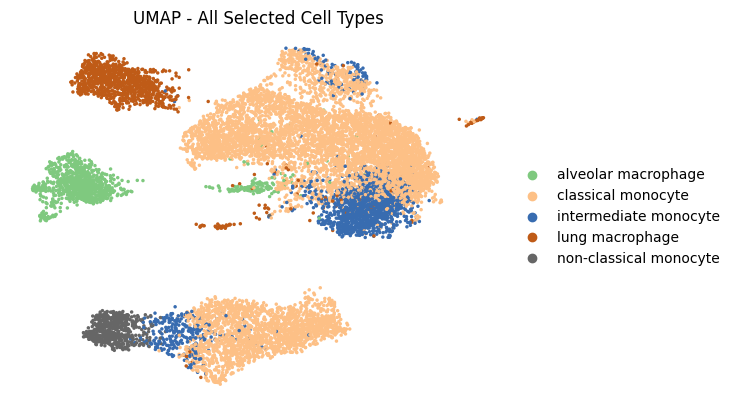

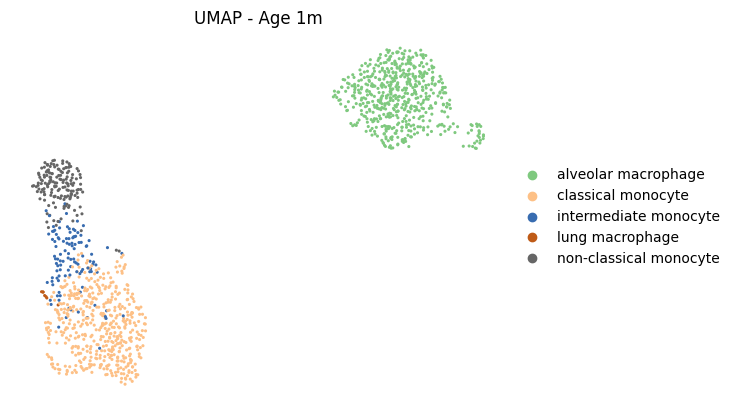

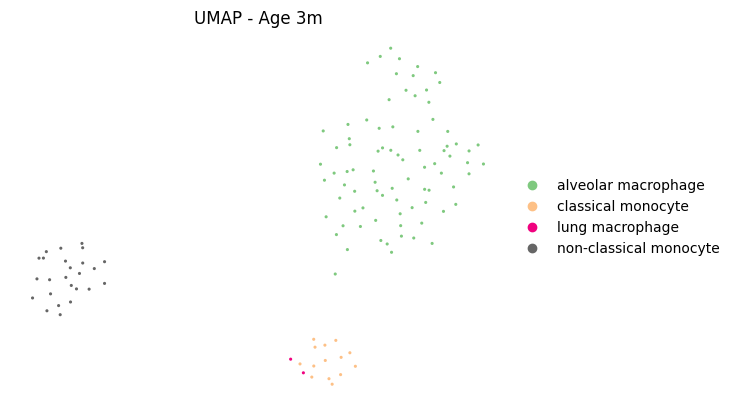

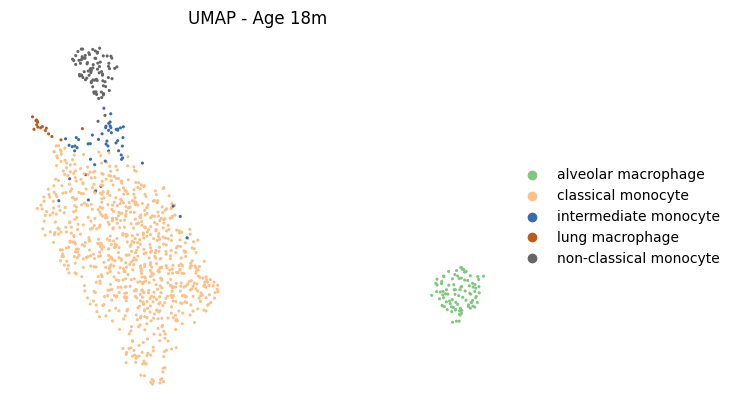

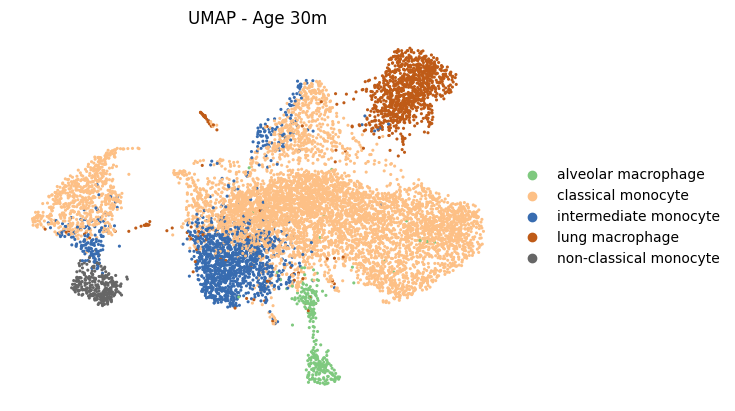

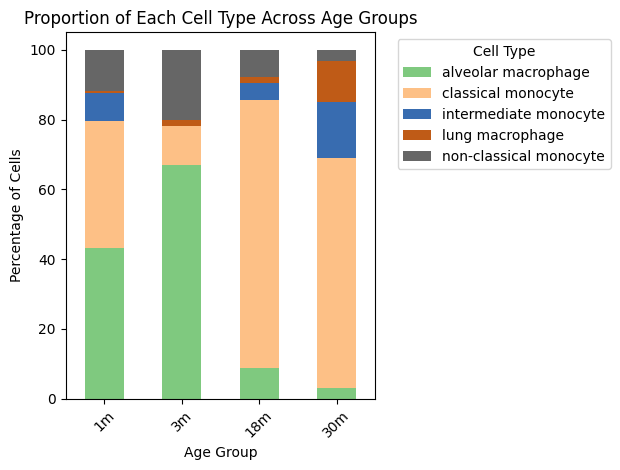

In [11]:
import os
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns

# Define the directory where you want to save the figures
save_dir = "/home/melhajjar/ipython_notebooks/tabula_muris_ageing_macrophages/figures"

# Ensure the directory exists; if not, create it
os.makedirs(save_dir, exist_ok=True)

# Merge selected cell types into one dataset
adata_selected = adata[adata.obs['cell_ontology_class'].isin(selected_adata_dfs.keys())].copy()

# General Preprocessing for Combined Data
print("Processing all selected cell types together...")

# Step 2: Normalize and log-transform
sc.pp.normalize_total(adata_selected, target_sum=1e4)
sc.pp.log1p(adata_selected)

# Step 1: Identify Highly Variable Genes
sc.pp.highly_variable_genes(adata_selected, n_top_genes=2000, batch_key="age")

# Step 3: Scale the data
sc.pp.scale(adata_selected, max_value=10)

# Step 4: PCA
sc.tl.pca(adata_selected)

# Step 5: Compute neighborhood graph
sc.pp.neighbors(adata_selected, n_pcs=50)

# Step 6: Compute UMAP
sc.tl.umap(adata_selected)

# Step 7: Plot general UMAP (all selected cell types together)
fig = plt.figure()
sc.pl.umap(
    adata_selected, 
    color="cell_ontology_class", 
    title="UMAP - All Selected Cell Types", 
    palette="Accent", 
    frameon=False, 
    size=25, 
    show=False
)
plt.savefig(os.path.join(save_dir, "UMAP_All_Selected_Cell_Types_Lung.pdf"), format="pdf", bbox_inches="tight")
plt.close(fig)  # Close to free memory

# Step 8: Separate UMAPs for Each Age Group
ages = sorted(adata_selected.obs['age'].unique(), key=lambda x: int(x.replace('m', '')))
dot_size = 20  # Consistent dot size for all plots

for age in ages:
    print(f"Processing age group {age}...")

    # Subset for the given age
    adata_age = adata_selected[adata_selected.obs["age"] == age].copy()

    # Compute UMAP for this age separately
    sc.pp.neighbors(adata_age)
    sc.tl.umap(adata_age)
    sc.tl.leiden(adata_age)  # Clustering

    # Plot UMAP with Leiden clusters
    fig = plt.figure()
    sc.pl.umap(
        adata_age,
        color="cell_ontology_class",
        title=f"UMAP - Age {age}",
        show=False,
        size=dot_size,
        frameon=False,
        palette="Accent"
    )
    plt.savefig(os.path.join(save_dir, f"UMAP_Lung_Age_{age}.pdf"), format="pdf", bbox_inches="tight")
    plt.close(fig)  # Close figure to free memory

# Step 9: Compute Cell Type Proportions for Each Age Group
cell_type_counts = adata_selected.obs.groupby(['age', 'cell_ontology_class']).size().unstack(fill_value=0)

# Convert counts to percentages within each age group
cell_type_percentages = cell_type_counts.div(cell_type_counts.sum(axis=1), axis=0) * 100

# Plot Bar Graph for Cell Type Proportions
fig = plt.figure(figsize=(10, 6))
cell_type_percentages.plot(kind='bar', stacked=True, cmap="Accent")

plt.ylabel("Percentage of Cells")
plt.xlabel("Age Group")
plt.title("Proportion of Each Cell Type Across Age Groups")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Save bar chart as a PDF
plt.savefig(os.path.join(save_dir, "Cell_Type_Proportions_Lung.pdf"), format="pdf", bbox_inches="tight")
plt.close(fig)  # Close figure

print(f"All figures have been saved in: {save_dir}")



In [12]:
import itertools
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Store results in a dictionary
p_values_dict = {}

for cell_type in cell_type_counts.columns:
    print(f"\n==== Fisher’s Exact Test for {cell_type} ====")

    # Get counts for this cell type
    cell_counts = cell_type_counts[cell_type]

    # Remove age groups with zero cells
    nonzero_ages = cell_counts[cell_counts > 0].index
    filtered_counts = cell_counts[nonzero_ages]

    # If fewer than 2 age groups remain, we cannot perform the test
    if len(filtered_counts) < 2:
        print(f"  → Skipping Fisher’s test for {cell_type} (not enough data).")
        continue

    # Initialize dictionary for this cell type
    p_values_dict[cell_type] = {}

    # Perform pairwise Fisher's Exact Test
    for age1, age2 in itertools.combinations(nonzero_ages, 2):
        table = np.array([
            [cell_counts[age1], cell_type_counts.sum(axis=1)[age1] - cell_counts[age1]],
            [cell_counts[age2], cell_type_counts.sum(axis=1)[age2] - cell_counts[age2]]
        ])

        # Run Fisher’s Exact Test
        _, p_value = stats.fisher_exact(table)

        # Store the true p-value (not rounded to zero)
        p_values_dict[cell_type][f"{age1} vs {age2}"] = max(p_value, np.finfo(float).tiny)  # Ensure small values are kept

        print(f"  → {cell_type} comparison ({age1} vs {age2}): P-Value = {p_value:.3e}")

# Convert dictionary to DataFrame for visualization
p_values_df = pd.DataFrame(p_values_dict).T  # Transpose for better visualization

# Replace NaN with 1 (since NaN means no comparison was possible)
p_values_df = p_values_df.fillna(1)


==== Fisher’s Exact Test for alveolar macrophage ====
  → alveolar macrophage comparison (1m vs 3m): P-Value = 4.105e-07
  → alveolar macrophage comparison (1m vs 18m): P-Value = 1.148e-84
  → alveolar macrophage comparison (1m vs 30m): P-Value = 0.000e+00
  → alveolar macrophage comparison (3m vs 18m): P-Value = 9.482e-47
  → alveolar macrophage comparison (3m vs 30m): P-Value = 1.308e-88
  → alveolar macrophage comparison (18m vs 30m): P-Value = 3.714e-16

==== Fisher’s Exact Test for classical monocyte ====
  → classical monocyte comparison (1m vs 3m): P-Value = 2.302e-09
  → classical monocyte comparison (1m vs 18m): P-Value = 2.030e-90
  → classical monocyte comparison (1m vs 30m): P-Value = 1.780e-92
  → classical monocyte comparison (3m vs 18m): P-Value = 1.060e-47
  → classical monocyte comparison (3m vs 30m): P-Value = 6.156e-36
  → classical monocyte comparison (18m vs 30m): P-Value = 9.251e-14

==== Fisher’s Exact Test for intermediate monocyte ====
  → intermediate monocyt

/tmp/ipykernel_6321/1287782584.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_labels = p_values_df.applymap(format_pval)


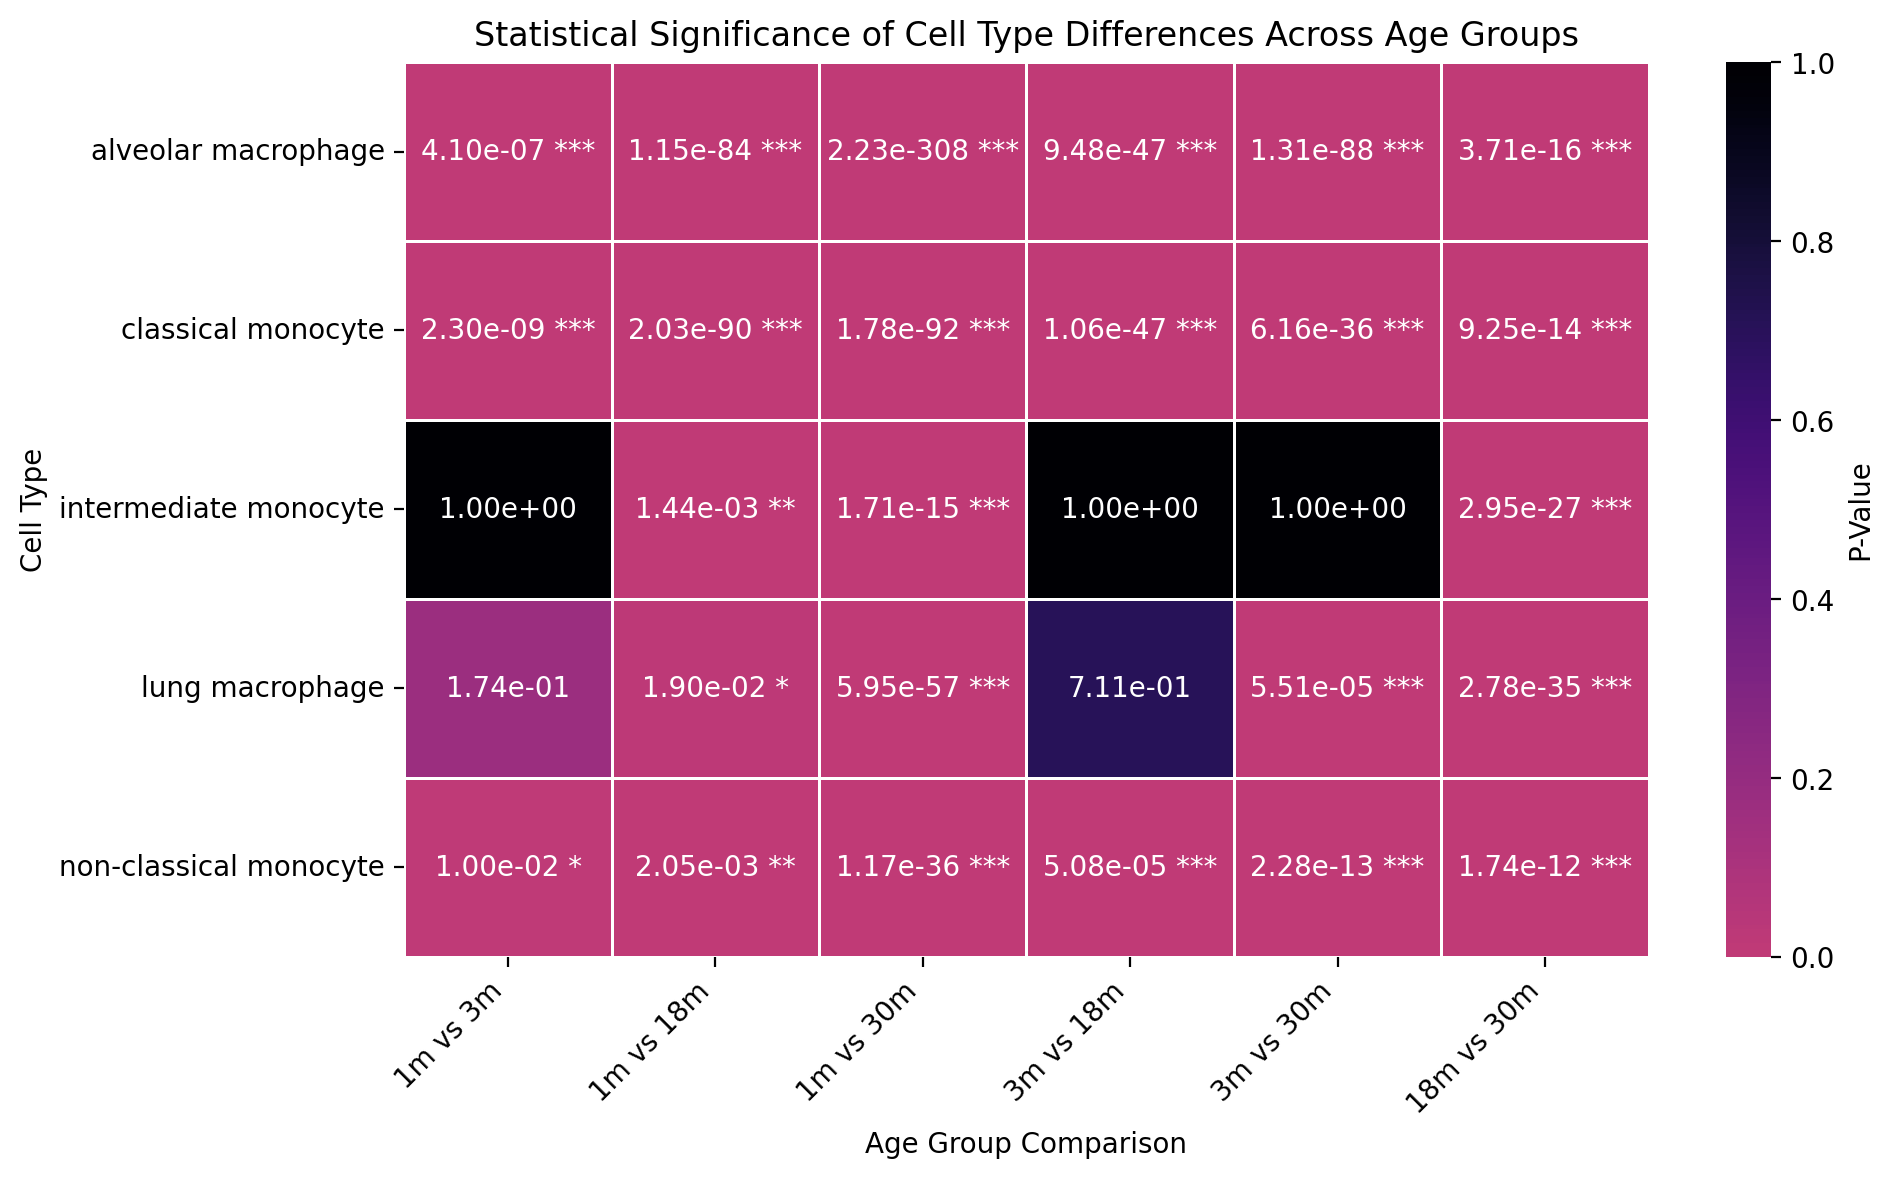

In [13]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to format p-values for annotation
def format_pval(p):
    """Formats p-values with scientific notation and adds significance markers."""
    if p < 0.001:
        return f"{p:.2e} ***"  # Highly significant
    elif p < 0.01:
        return f"{p:.2e} **"   # Moderately significant
    elif p < 0.05:
        return f"{p:.2e} *"    # Significant
    else:
        return f"{p:.2e}"      # Not significant

# Apply the function to format the heatmap labels
annot_labels = p_values_df.applymap(format_pval)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    p_values_df, 
    annot=annot_labels,  # Use formatted labels with significance markers
    cmap="magma_r", 
    center=0.05,  
    linewidths=0.5,
    cbar_kws={'label': 'P-Value'},
    fmt="",  # Disable default number formatting
    annot_kws={"size": 10}  # Adjust font size for readability
)

plt.title("Statistical Significance of Cell Type Differences Across Age Groups")
plt.xlabel("Age Group Comparison")
plt.ylabel("Cell Type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

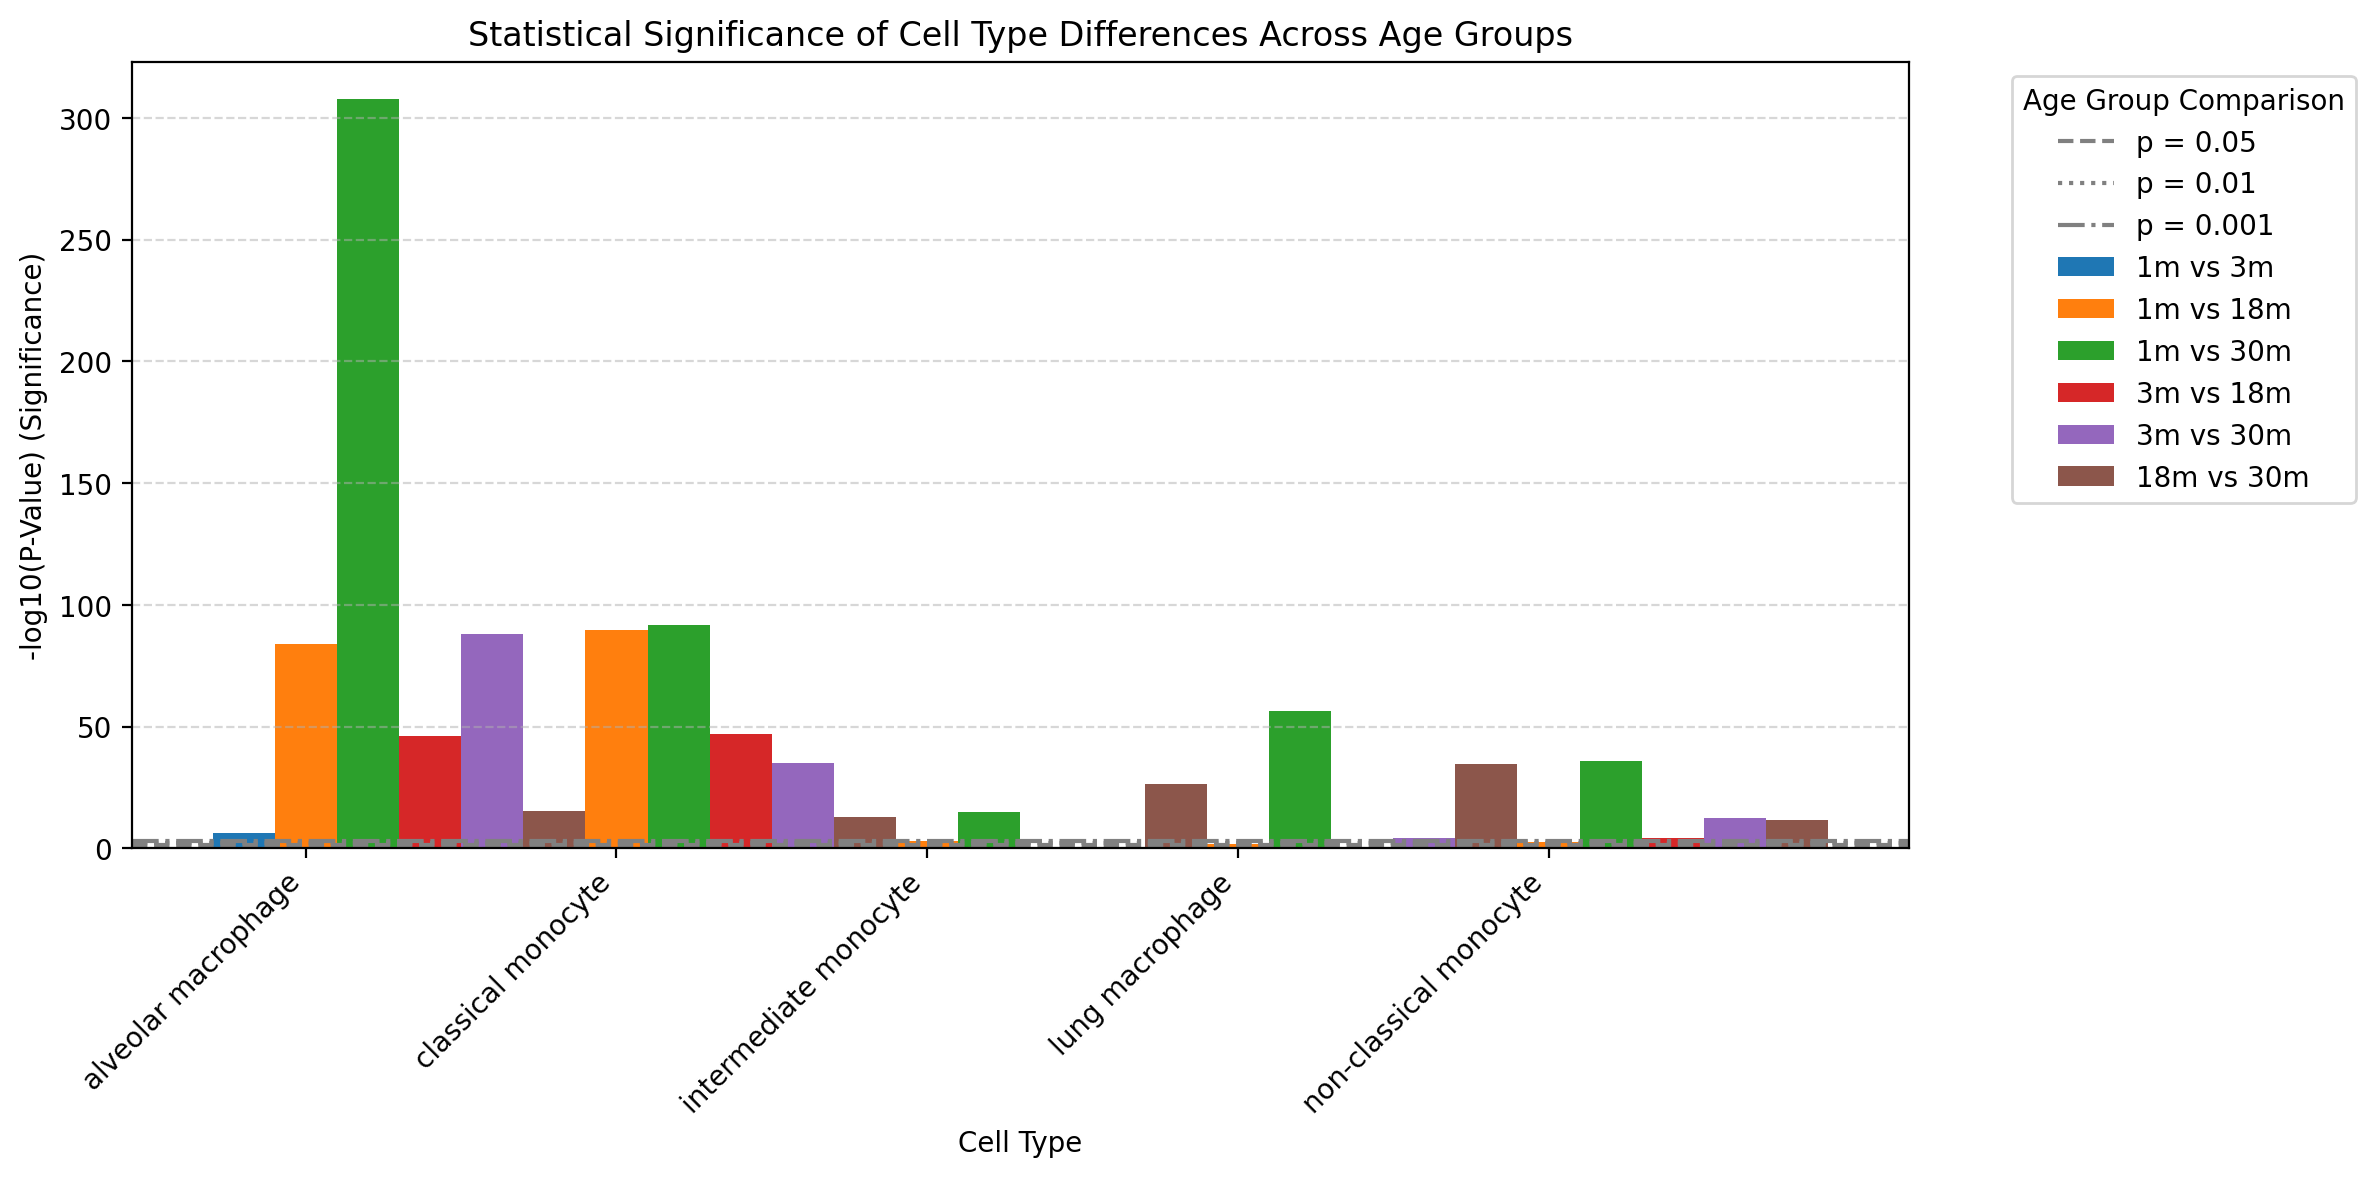

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert p-values to log scale for better visualization
p_values_log = -np.log10(p_values_df)  # Transform p-values for better scaling

# Set up the figure
plt.figure(figsize=(12, 6))

# Bar width and spacing
bar_width = 0.2
x_labels = np.arange(len(p_values_log.index))  # Position for cell types

# Plot bars for each age group comparison
for i, age_group in enumerate(p_values_log.columns):
    plt.bar(x_labels + i * bar_width, p_values_log[age_group], width=bar_width, label=age_group)

# Formatting
plt.xticks(x_labels + bar_width, p_values_log.index, rotation=45, ha='right')  # Cell types
plt.axhline(-np.log10(0.05), color='gray', linestyle='dashed', label="p = 0.05")
plt.axhline(-np.log10(0.01), color='gray', linestyle='dotted', label="p = 0.01")
plt.axhline(-np.log10(0.001), color='gray', linestyle='dashdot', label="p = 0.001")

plt.ylabel("-log10(P-Value) (Significance)")
plt.xlabel("Cell Type")
plt.title("Statistical Significance of Cell Type Differences Across Age Groups")
plt.legend(title="Age Group Comparison", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()



In [19]:
cell_type_counts

cell_ontology_class,alveolar macrophage,classical monocyte,intermediate monocyte,lung macrophage,non-classical monocyte
age,,,,,
1m,577,486,111,7,157
3m,83,14,0,2,25
18m,94,819,53,16,84
30m,290,6088,1495,1098,287


/bioinformatics/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


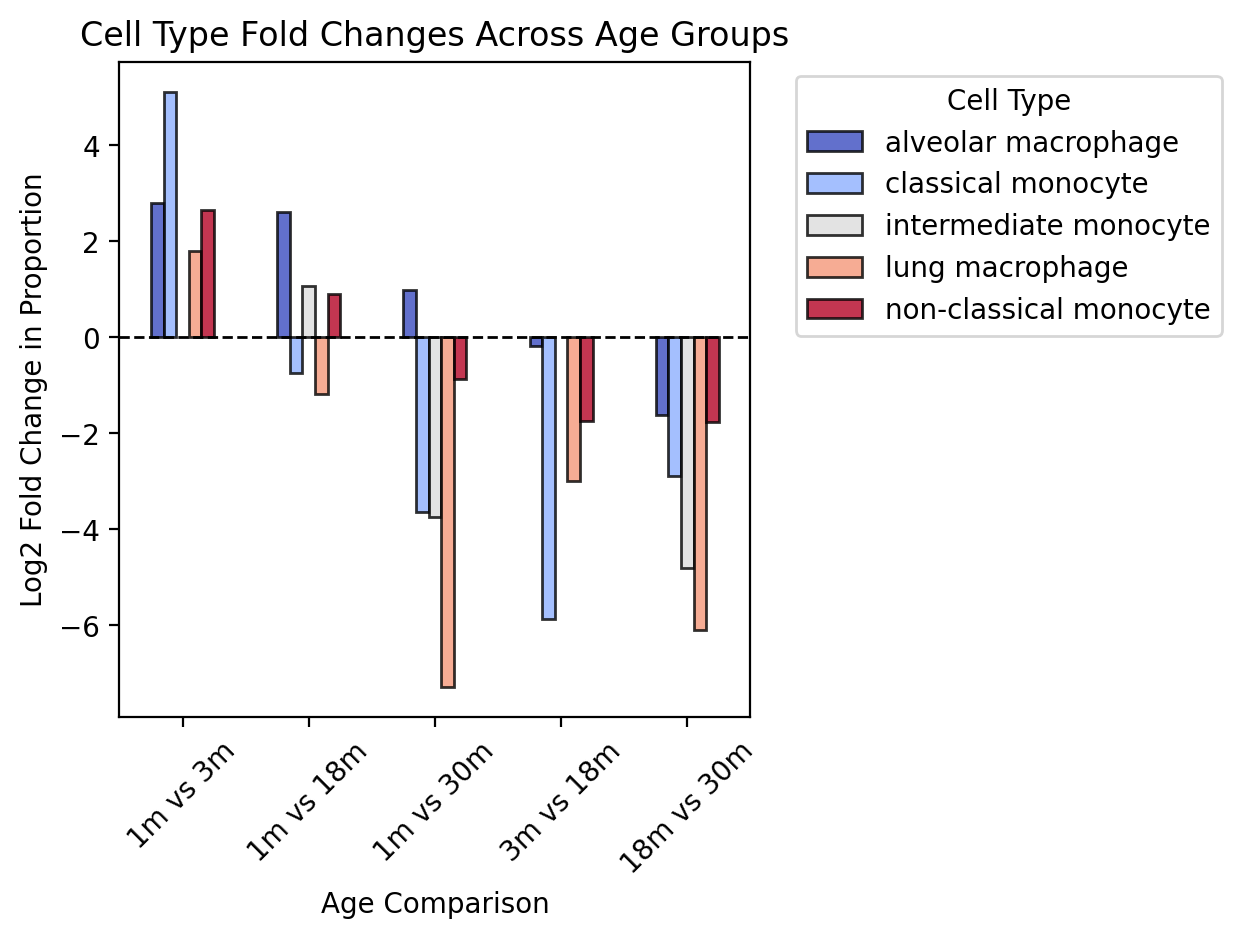

In [23]:
# Define specific comparisons (manually set reference for each pair)
comparisons = [
    ("1m", "3m"),
    ("1m", "18m"),
    ("1m", "30m"),
    ("3m", "18m"),
    ("18m", "30m")
]

# Compute log2 fold change only for defined comparisons
fold_change_dict = {}

for newer, older in comparisons:
    fold_change_dict[f"{newer} vs {older}"] = np.log2(cell_type_counts.loc[newer] / cell_type_counts.loc[older])

# Convert to DataFrame
fold_change_df = pd.DataFrame(fold_change_dict)

# Transpose so that age comparisons are on the x-axis
fold_change_df = fold_change_df.T

# Plot
fold_change_df.plot(kind="bar", cmap="coolwarm", edgecolor="black", alpha=0.8)
plt.axhline(0, color="black", linestyle="--", linewidth=1)  # Baseline
plt.ylabel("Log2 Fold Change in Proportion")
plt.xlabel("Age Comparison")
plt.title("Cell Type Fold Changes Across Age Groups")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.savefig(os.path.join(save_dir, "Cell_Type_LogFoldChange_Ageing_Lung.pdf"), format="pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()


In [17]:
print(cell_type_counts.loc["1m"])


cell_ontology_class
alveolar macrophage       577
classical monocyte        486
intermediate monocyte     111
lung macrophage             7
non-classical monocyte    157
Name: 1m, dtype: int64


/tmp/ipykernel_11770/2183243052.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_labels = p_values_df.applymap(format_pval)


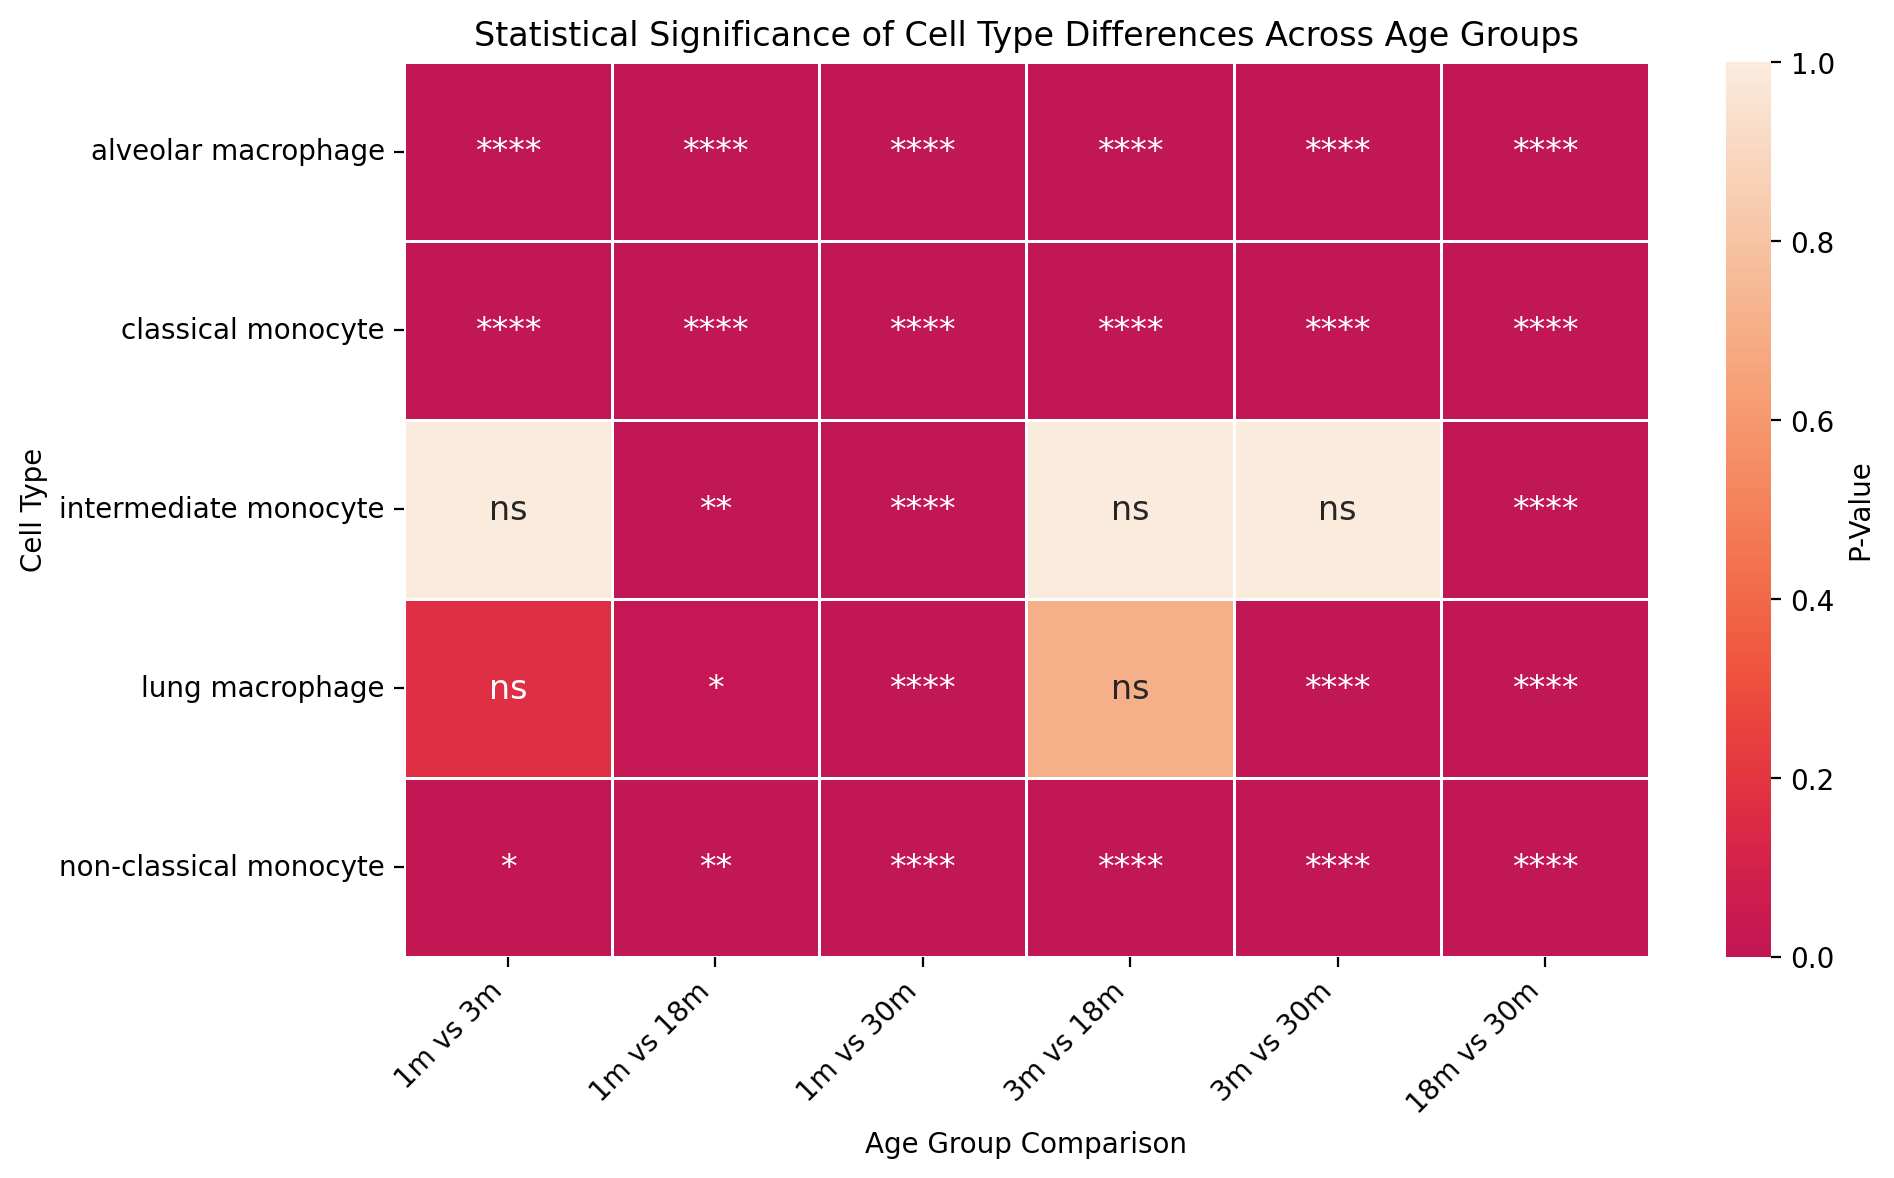

In [25]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to format p-values for annotation
def format_pval(p):
    """Formats p-values as significance markers only."""
    if p < 0.0001:
        return "****"  # Extremely significant
    elif p < 0.001:
        return "***"  # Highly significant
    elif p < 0.01:
        return "**"   # Moderately significant
    elif p < 0.05:
        return "*"    # Significant
    else:
        return "ns"   # Not significant

# Apply the function to format the heatmap labels
annot_labels = p_values_df.applymap(format_pval)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    p_values_df, 
    annot=annot_labels,  # Use significance markers instead of numbers
    cmap="rocket", 
    center=0.05,  
    linewidths=0.5,
    cbar_kws={'label': 'P-Value'},
    fmt="",  # Disable default number formatting
    annot_kws={"size": 12}  # Adjust font size for readability
)

plt.title("Statistical Significance of Cell Type Differences Across Age Groups")
plt.xlabel("Age Group Comparison")
plt.ylabel("Cell Type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
